# Geração de Faces com GANs (Generative Adversarial Networks)

Este notebook implementa uma DCGAN (Deep Convolutional GAN) para gerar
imagens faciais realistas usando o dataset CelebA.

Autor: Lucas Lattari (Universo Discreto)

Data: 06/04/25

#1. Configuração do Ambiente

In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython import display

# Verificar versão do TensorFlow (deve ser 2.x)
print(f"TensorFlow versão: {tf.__version__}")

# Verificar se GPU está disponível (recomendado para treinar GANs)
print("GPUs Disponíveis:", tf.config.list_physical_devices('GPU'))
if tf.config.list_physical_devices('GPU'):
    print("GPU está disponível e será usada para treinamento!")
else:
    print("ATENÇÃO: GPU não detectada. O treinamento será muito mais lento em CPU.")

# Configurações globais para melhor desempenho
tf.keras.backend.clear_session()  # Limpa sessão do Keras
print("Configuração do ambiente concluída!")

TensorFlow versão: 2.18.0
GPUs Disponíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU está disponível e será usada para treinamento!
Configuração do ambiente concluída!


#2: Montar Google Drive para acessar o dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Verificar se o arquivo tfrecord existe
DATASET_PATH = "/content/drive/MyDrive/celeba_subset.tfrecord"
if os.path.exists(DATASET_PATH):
    print(f"Dataset encontrado em: {DATASET_PATH}")
else:
    print(f"ERRO: Dataset não encontrado em {DATASET_PATH}")
    print("Por favor, verifique o caminho do arquivo.")

Mounted at /content/drive
Dataset encontrado em: /content/drive/MyDrive/celeba_subset.tfrecord


#3: Definição de hiperparâmetros

Nesta célula, definimos os hiperparâmetros que controlam o comportamento do nosso modelo:

In [ ]:
# Hiperparâmetros do modelo
BATCH_SIZE = 64          # Tamanho do lote de treinamento
IMG_SIZE = 64             # Resolução das imagens (64x64 pixels)
LATENT_DIM = 128          # Dimensão do vetor de ruído de entrada (espaço latente)
EPOCHS = 150               # Número de épocas para treinar
DISPLAY_INTERVAL = 20     # Exibir progresso a cada N batches
SAVE_INTERVAL = 500       # Salvar checkpoint a cada N batches
NUM_EXAMPLES_TO_GENERATE = 16  # Número de exemplos a gerar durante o treinamento

USE_CHECKPOINTS = False    # Se True, usa checkpoints existentes. Se False, inicia treinamento do zero

LR_ADJUSTMENT_FREQUENCY = 2  # Ajustar taxas a cada N épocas
DISC_LR_DECAY_RATE = 0.75    # Taxa de decaimento para LR do discriminador quando estiver muito forte
GEN_LR_BOOST_RATE = 1.2     # Taxa de aumento para LR do gerador quando estiver com dificuldades
MIN_DISC_LR = 0.00001        # Taxa de aprendizado mínima para o discriminador
MAX_GEN_LR = 0.001           # Taxa de aprendizado máxima para o gerador
G_D_RATIO_THRESHOLD = 1.5    # Quando a razão G:D excede isso, ajustar taxas de aprendizado

# Hiperparâmetros de otimização
GEN_LR = 0.0001           # Reduzido de 0.0002
DISC_LR = 0.0004          # Aumentado em relação ao original
BETA1 = 0.5               # Parâmetro beta1 para o otimizador Adam

# Diretório para salvar checkpoints
CHECKPOINT_DIR = './training_checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Diretório para salvar logs e resultados
LOG_DIR = './logs'
os.makedirs(LOG_DIR, exist_ok=True)

print("Hiperparâmetros configurados!")

Hiperparâmetros configurados!


#4: Funções para carregamento e pré-processamento de dados

Nesta célula, definimos funções para carregar e pré-processar o dataset CelebA.
Usamos a API tf.data para criar um pipeline de dados eficiente.

Dataset carregado com sucesso!


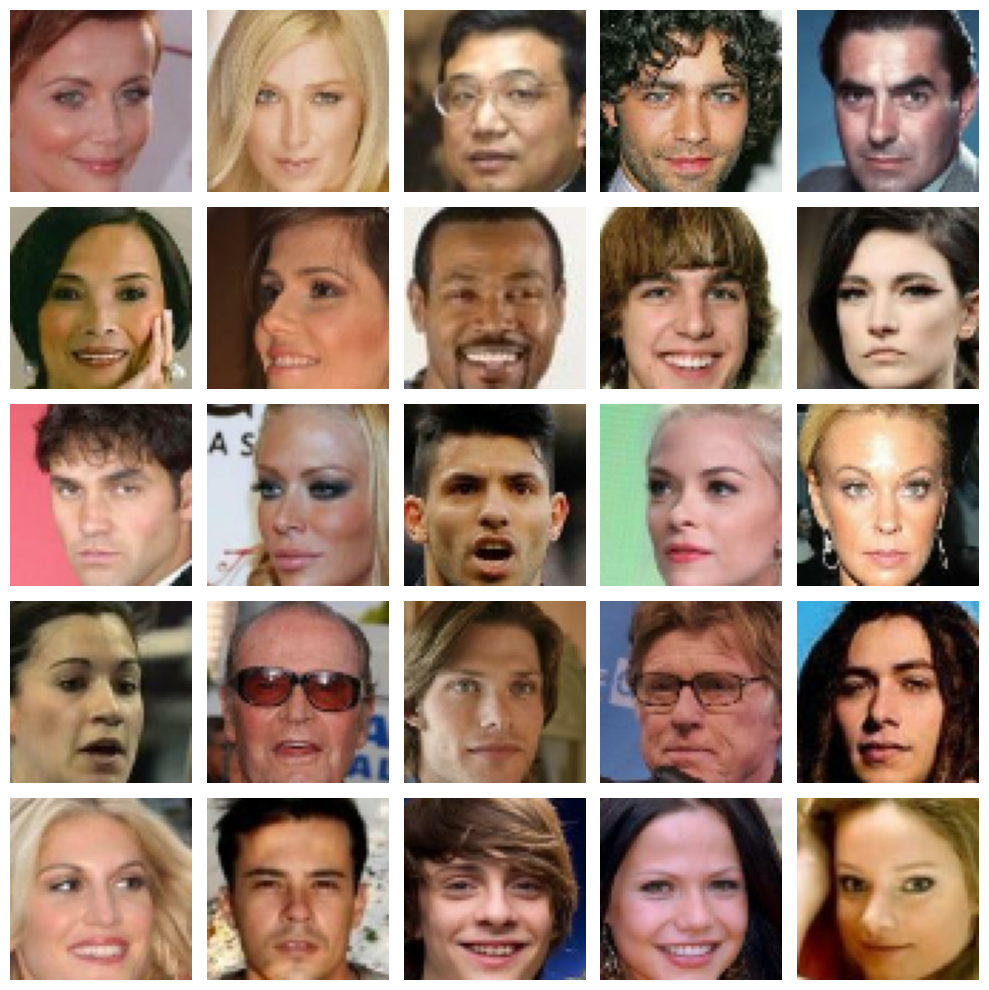

In [ ]:
def parse_tfrecord(example):
    """Função para analisar um exemplo do TFRecord."""
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, features)
    img = tf.io.decode_jpeg(example['image'], channels=3)
    return img

def preprocess_image(image):
    """Pré-processa a imagem para treinar a GAN, com foco nas faces usando TensorFlow."""
    import tensorflow as tf

    # Obtém dimensões da imagem
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]

    # Definir as proporções de cropping relativas para faces
    # Baseado nos valores (30, 55, 150, 175) para imagens de tamanho aproximado 178x218
    # Convertendo para proporções relativas
    left_ratio = 30.0 / 178.0
    top_ratio = 55.0 / 218.0
    right_ratio = 150.0 / 178.0
    bottom_ratio = 175.0 / 218.0

    # Calcular as coordenadas absolutas baseadas nas proporções
    left = tf.cast(tf.cast(width, tf.float32) * left_ratio, tf.int32)
    top = tf.cast(tf.cast(height, tf.float32) * top_ratio, tf.int32)
    right = tf.cast(tf.cast(width, tf.float32) * right_ratio, tf.int32)
    bottom = tf.cast(tf.cast(height, tf.float32) * bottom_ratio, tf.int32)

    # Largura e altura do crop
    crop_width = right - left
    crop_height = bottom - top

    # Aplicar o crop usando TensorFlow
    cropped_image = tf.image.crop_to_bounding_box(
        image,
        top,
        left,
        crop_height,
        crop_width
    )

    # Redimensionar para IMG_SIZE x IMG_SIZE
    resized_image = tf.image.resize(cropped_image, [IMG_SIZE, IMG_SIZE])

    # Normalizar os valores de pixel para [-1, 1]
    normalized_image = (tf.cast(resized_image, tf.float32) / 127.5) - 1.0

    return normalized_image

def load_dataset(tfrecord_path, batch_size=BATCH_SIZE):
    """Carrega e prepara o dataset a partir do arquivo TFRecord."""
    # Carrega o arquivo TFRecord
    dataset = tf.data.TFRecordDataset(tfrecord_path)

    # Analisa, pré-processa e prepara batches
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Prefetch próximos batches

    return dataset

# Carregar o dataset
try:
    dataset = load_dataset(DATASET_PATH)
    print("Dataset carregado com sucesso!")

    # Visualizar algumas imagens para verificar se o pré-processamento está correto
    sample_batch = next(iter(dataset))
    plt.figure(figsize=(10, 10))
    for i in range(min(25, len(sample_batch))):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow((sample_batch[i] * 0.5 + 0.5))  # Desnormaliza para [0, 1]
        plt.axis('off')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Erro ao carregar o dataset: {e}")

In [ ]:
def contar_imagens_tfrecord(tfrecord_path):
    """Conta o número total de exemplos em um arquivo TFRecord."""
    # Cria um dataset a partir do arquivo TFRecord
    dataset = tf.data.TFRecordDataset(tfrecord_path)

    # Usa reduce para contar os exemplos
    count = dataset.reduce(0, lambda count, _: count + 1)

    return count

# Obter o total de imagens
try:
    total_imagens = contar_imagens_tfrecord(DATASET_PATH)
    print(f"Total de imagens no TFRecord: {total_imagens}")
except Exception as e:
    print(f"Erro ao contar imagens: {e}")

Total de imagens no TFRecord: 100000


# 4.1: Verificação da Qualidade das Imagens

Dataset carregado com sucesso!

=== VERIFICAÇÃO DE QUALIDADE DAS IMAGENS ===
Intervalo de valores da imagem normalizada: [-1.0000, 1.0000]
Intervalo esperado: [-1.0, 1.0]
✓ Normalização verificada: valores dentro do intervalo esperado.

Forma do lote de imagens: (64, 64, 64, 3)
  - Número de imagens no lote: 64
  - Altura das imagens: 64 pixels
  - Largura das imagens: 64 pixels
  - Canais de cor: 3
✓ Dimensões verificadas: imagens 64x64 com 3 canais (RGB).

Visualizando amostra de imagens processadas:
Estatísticas das imagens (após desnormalização):
  - Média dos valores de pixel: 0.4472
  - Desvio padrão: 0.2603
  - Imagens potencialmente muito escuras: 0 de 64
  - Imagens potencialmente muito claras: 0 de 64


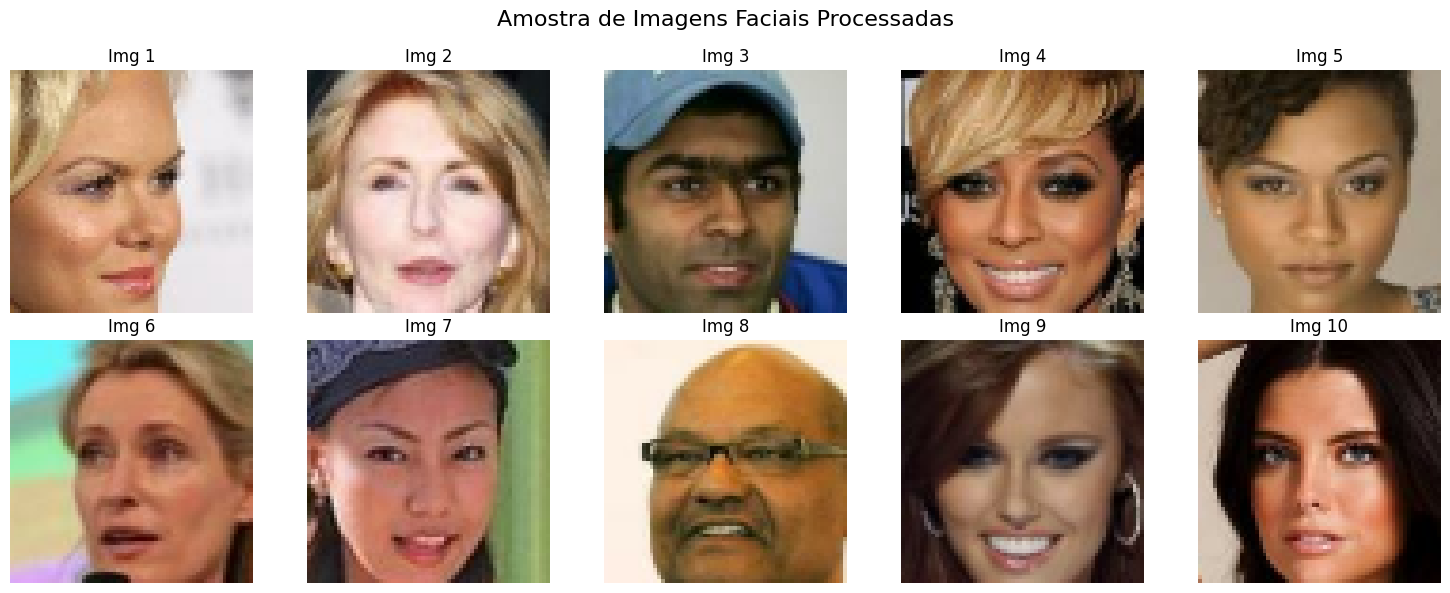

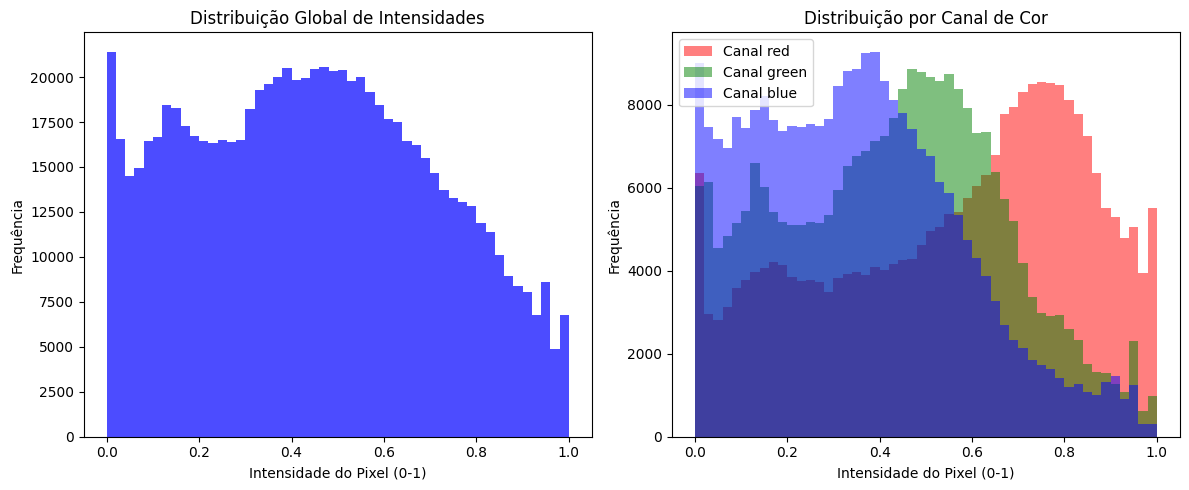

=== FIM DA VERIFICAÇÃO DE QUALIDADE ===



In [ ]:
def verify_image_quality(dataset):
    """
    Verifica a qualidade das imagens processadas usando várias técnicas de validação.

    Args:
        dataset: Um dataset do TensorFlow contendo as imagens processadas
    """
    import tensorflow as tf
    import numpy as np
    import matplotlib.pyplot as plt

    # Extrair um lote de imagens para verificação
    sample_batch = next(iter(dataset))

    # 1. Verificar valores mínimos e máximos (normalização)
    # Como as imagens estão normalizadas para [-1, 1], esperamos valores nesse intervalo
    min_val = tf.reduce_min(sample_batch)
    max_val = tf.reduce_max(sample_batch)
    print(f"Intervalo de valores da imagem normalizada: [{min_val:.4f}, {max_val:.4f}]")
    print(f"Intervalo esperado: [-1.0, 1.0]")

    if min_val < -1.1 or max_val > 1.1:  # Pequena margem de erro
        print("⚠️ ATENÇÃO: Valores fora do intervalo esperado!")
    else:
        print("✓ Normalização verificada: valores dentro do intervalo esperado.")

    # 2. Verificar as dimensões (shape) das imagens
    batch_shape = sample_batch.shape
    print(f"\nForma do lote de imagens: {batch_shape}")
    print(f"  - Número de imagens no lote: {batch_shape[0]}")
    print(f"  - Altura das imagens: {batch_shape[1]} pixels")
    print(f"  - Largura das imagens: {batch_shape[2]} pixels")
    print(f"  - Canais de cor: {batch_shape[3]}")

    if batch_shape[1] == IMG_SIZE and batch_shape[2] == IMG_SIZE and batch_shape[3] == 3:
        print(f"✓ Dimensões verificadas: imagens {IMG_SIZE}x{IMG_SIZE} com 3 canais (RGB).")
    else:
        print(f"⚠️ ATENÇÃO: Dimensões não correspondem ao esperado ({IMG_SIZE}x{IMG_SIZE}x3)!")

    # 3. Verificar visualmente a qualidade e consistência das imagens
    print("\nVisualizando amostra de imagens processadas:")

    # Desnormalizar para [0, 1] para visualização
    display_images = (sample_batch * 0.5) + 0.5

    # Calcular estatísticas básicas das imagens (em valores desnormalizados)
    mean_val = tf.reduce_mean(display_images)
    std_val = tf.math.reduce_std(display_images)
    print(f"Estatísticas das imagens (após desnormalização):")
    print(f"  - Média dos valores de pixel: {mean_val:.4f}")
    print(f"  - Desvio padrão: {std_val:.4f}")

    # Verificar se há imagens muito escuras ou muito claras
    dark_images = tf.reduce_sum(tf.cast(tf.reduce_mean(display_images, axis=[1, 2, 3]) < 0.2, tf.int32))
    bright_images = tf.reduce_sum(tf.cast(tf.reduce_mean(display_images, axis=[1, 2, 3]) > 0.8, tf.int32))
    print(f"  - Imagens potencialmente muito escuras: {dark_images} de {batch_shape[0]}")
    print(f"  - Imagens potencialmente muito claras: {bright_images} de {batch_shape[0]}")

    # Criar grade de visualização 2x5 (10 imagens)
    plt.figure(figsize=(15, 6))
    for i in range(min(10, batch_shape[0])):
        plt.subplot(2, 5, i + 1)
        plt.imshow(display_images[i])
        plt.title(f"Img {i+1}")
        plt.axis('off')

    plt.suptitle("Amostra de Imagens Faciais Processadas", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

    # Verificação adicional: histograma de intensidades para verificar contraste
    plt.figure(figsize=(12, 5))

    # Histograma global (todas as imagens no batch)
    plt.subplot(1, 2, 1)
    plt.hist(tf.reshape(display_images, [-1]).numpy(), bins=50, color='blue', alpha=0.7)
    plt.title("Distribuição Global de Intensidades")
    plt.xlabel("Intensidade do Pixel (0-1)")
    plt.ylabel("Frequência")

    # Histograma por canal de cor
    plt.subplot(1, 2, 2)
    colors = ['red', 'green', 'blue']
    for c in range(3):
        plt.hist(tf.reshape(display_images[:, :, :, c], [-1]).numpy(),
                bins=50, color=colors[c], alpha=0.5, label=f'Canal {colors[c]}')
    plt.title("Distribuição por Canal de Cor")
    plt.xlabel("Intensidade do Pixel (0-1)")
    plt.ylabel("Frequência")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return sample_batch  # Retorna o batch para análises adicionais se necessário

# Adicione o seguinte código após o carregamento do dataset e antes do treinamento
try:
    dataset = load_dataset(DATASET_PATH)
    print("Dataset carregado com sucesso!")

    # Executar verificação de qualidade
    print("\n=== VERIFICAÇÃO DE QUALIDADE DAS IMAGENS ===")
    verify_image_quality(dataset)
    print("=== FIM DA VERIFICAÇÃO DE QUALIDADE ===\n")

except Exception as e:
    print(f"Erro ao carregar ou verificar o dataset: {e}")

#5: Construção do Gerador

O Gerador transforma um vetor de ruído aleatório em uma imagem de face.
Ele usa camadas de convolução transposta (deconvolução) para aumentar
gradualmente a resolução da imagem gerada.

Arquitetura do Gerador:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 12288)               │       1,572,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12288)               │          49,152 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 12288)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 768)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 384)           │       4,718,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 384)           │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 8, 8, 384)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 8, 8, 384)           │       1,327,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 384)           │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8, 8, 384)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 192)         │       1,179,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 192)         │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 192)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 192)         │         331,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 192)         │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 16, 16, 192)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 96)          │         294,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 96)          │             3

 Total params: 9,658,515 (36.84 MB)

 Trainable params: 9,631,059 (36.74 MB)

 Non-trainable params: 27,456 (107.25 KB)

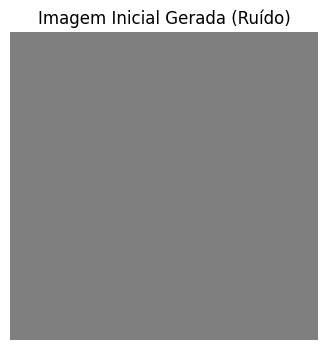

In [ ]:
def build_generator():
    """
    Constrói um modelo de gerador mais complexo com capacidade expressiva aumentada.
    """
    inputs = tf.keras.layers.Input(shape=(LATENT_DIM,))

    # Camada densa inicial + reshape para tensor 3D (aumentando filtros)
    x = tf.keras.layers.Dense(4 * 4 * 768, use_bias=False)(inputs)  # Aumentado de 512 para 768
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)
    x = tf.keras.layers.Reshape((4, 4, 768))(x)

    # Camada de upsampling 1: 4x4 -> 8x8 (maior e com camada extra)
    x = tf.keras.layers.Conv2DTranspose(384, kernel_size=4, strides=2, padding='same', use_bias=False)(x)  # 256->384
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)
    # Camada extra sem alterar dimensões espaciais
    x = tf.keras.layers.Conv2D(384, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)

    # Camada de upsampling 2: 8x8 -> 16x16 (maior e com camada extra)
    x = tf.keras.layers.Conv2DTranspose(192, kernel_size=4, strides=2, padding='same', use_bias=False)(x)  # 128->192
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)
    # Camada extra sem alterar dimensões espaciais
    x = tf.keras.layers.Conv2D(192, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)

    # Camada de upsampling 3: 16x16 -> 32x32 (maior e com camada extra)
    x = tf.keras.layers.Conv2DTranspose(96, kernel_size=4, strides=2, padding='same', use_bias=False)(x)  # 64->96
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)
    # Camada extra sem alterar dimensões espaciais
    x = tf.keras.layers.Conv2D(96, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)

    # Camada de upsampling 4: 32x32 -> 64x64
    x = tf.keras.layers.Conv2DTranspose(48, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)

    # Camada adicional de refinamento
    x = tf.keras.layers.Conv2D(48, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)

    # Camada final
    outputs = tf.keras.layers.Conv2D(3, kernel_size=3, strides=1, padding='same',
                                      use_bias=True, activation='tanh')(x)

    # Criar o modelo
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="generator")

    return model

# Criar o gerador
generator = build_generator()

# Visualizar a arquitetura do gerador
print("Arquitetura do Gerador:")
generator.summary()

# Gerar uma imagem a partir de ruído aleatório para teste
noise = tf.random.normal([1, LATENT_DIM])
generated_image = generator(noise, training=False)
plt.figure(figsize=(4, 4))
plt.imshow((generated_image[0, :, :, :] * 0.5 + 0.5))  # Desnormaliza de [-1,1] para [0,1]
plt.axis('off')
plt.title('Imagem Inicial Gerada (Ruído)')
plt.show()

#6: Construção do Discriminador

O Discriminador é um classificador que tenta distinguir imagens reais de imagens geradas.
Ele usa camadas convolucionais para reduzir gradualmente a resolução da imagem,
extraindo características para determinar se a imagem é real ou falsa.

In [ ]:
def build_discriminator():
    """
    Constrói o modelo do discriminador com camada Input explícita.
    """
    inputs = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3])

    # Camada conv 1: 64x64 -> 32x32
    x = tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Camada conv 2: 32x32 -> 16x16
    x = tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Camada conv 3: 16x16 -> 8x8
    x = tf.keras.layers.Conv2D(256, kernel_size=5, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Camada conv 4: 8x8 -> 4x4
    x = tf.keras.layers.Conv2D(512, kernel_size=5, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Camada de saída
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(1)(x)

    # Criar o modelo
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="discriminator")

    return model

# Criar o discriminador
discriminator = build_discriminator()

# Visualizar a arquitetura do discriminador
print("Arquitetura do Discriminador:")
discriminator.summary()

Arquitetura do Discriminador:


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 4, 4, 512)           │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,318,337 (16.47 MB)

 Trainable params: 4,316,545 (16.47 MB)

 Non-trainable params: 1,792 (7.00 KB)

#7: Definição das funções de perda e otimizadores

Nesta célula, definimos as funções de perda para o gerador e discriminador,
além dos otimizadores para treinar cada rede.

In [ ]:
# Função de perda
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Função de perda do discriminador com label smoothing
def discriminator_loss(real_output, fake_output, real_labels=None, fake_labels=None):
    if real_labels is None:
        real_labels = tf.ones_like(real_output) * 0.9  # Label smoothing: 0.9 em vez de 1.0
    if fake_labels is None:
        fake_labels = tf.zeros_like(fake_output)

    real_loss = cross_entropy(real_labels, real_output)
    fake_loss = cross_entropy(fake_labels, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Função de perda do gerador
def generator_loss(fake_output):
    """Calcula a perda do gerador."""
    # O gerador quer que o discriminador classifique suas imagens como reais (1)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Otimizadores com taxas de aprendizado ajustadas
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=GEN_LR, beta_1=BETA1)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=DISC_LR, beta_1=BETA1)

#8: Setup para visualização e checkpoints

Configuramos funções para visualizar resultados e salvar checkpoints.

In [ ]:
# Seed para gerar imagens consistentes ao longo do treinamento
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, LATENT_DIM])

# Função para gerar e salvar imagens
def generate_and_save_images(model, epoch, step, test_input):
    """Gera imagens a partir do modelo e as salva como uma figura."""
    # Modo de inferência para o gerador
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        # Desnormaliza as imagens de [-1, 1] para [0, 1]
        plt.imshow((predictions[i, :, :, :] * 0.5 + 0.5))
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'{LOG_DIR}/image_at_epoch_{epoch:04d}_step_{step:06d}.png')
    plt.close(fig)

    return predictions

# Criar um novo diretório para checkpoints
CHECKPOINT_DIR = './training_checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Configurar o gerenciador de checkpoint
checkpoint_prefix = os.path.join(CHECKPOINT_DIR, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)
checkpoint_manager = tf.train.CheckpointManager(
    checkpoint, directory=CHECKPOINT_DIR, max_to_keep=3
)

start_epoch = 0

# Verificar se devemos carregar checkpoints existentes
if USE_CHECKPOINTS:
    # Verificar se existem checkpoints
    latest_checkpoint = checkpoint_manager.latest_checkpoint
    if latest_checkpoint:
        # Restaurar o modelo do último checkpoint
        status = checkpoint.restore(latest_checkpoint)
        print(f"Checkpoint restaurado: {latest_checkpoint}")

        # Extrair o número da época do nome do checkpoint (opcional)
        try:
            checkpoint_epoch = int(latest_checkpoint.split('-')[-1])
            start_epoch = checkpoint_epoch + 1
            print(f"Retomando treinamento da época {start_epoch}")
        except:
            print("Não foi possível determinar a época do checkpoint. Iniciando da época 0.")
    else:
        print("Nenhum checkpoint encontrado. Iniciando treinamento do zero.")
else:
    # Se USE_CHECKPOINTS é False, remover todos os checkpoints existentes
    import shutil
    if os.path.exists(CHECKPOINT_DIR):
        shutil.rmtree(CHECKPOINT_DIR)
        os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    print("Checkpoints anteriores removidos.")

print("Iniciando treinamento" + (" a partir do checkpoint" if USE_CHECKPOINTS and checkpoint_manager.latest_checkpoint else " do zero") + ".")

# Listas para armazenar métricas de perda para plotagem
history = {
    'gen_loss': [],
    'disc_loss': [],
    'steps': []
}

Checkpoints anteriores removidos.
Iniciando treinamento do zero.


# 9: Função de treinamento por passo

Esta função implementa um único passo de treinamento para a GAN.
Primeiro, treina o discriminador e depois o gerador.

In [ ]:
# Adicione este parâmetro aos hiperparâmetros globais
N_GENERATOR_UPDATES = 1  # Número de atualizações do gerador para cada atualização do discriminador

@tf.function
def train_step(images):
    """Executa um passo de treinamento com múltiplas atualizações do gerador."""
    # Variáveis para rastrear as perdas
    total_gen_loss = 0.0

    # 1. Primeiro, treinar o discriminador uma vez
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as disc_tape:
        # Gerar imagens falsas
        generated_images = generator(noise, training=True)

        # Adicionar pequeno ruído às imagens (tanto reais quanto falsas)
        noise_factor = 0.05
        noisy_real_images = images + noise_factor * tf.random.normal(shape=tf.shape(images))
        noisy_fake_images = generated_images + noise_factor * tf.random.normal(shape=tf.shape(generated_images))

        # Classificar imagens reais e falsas com ruído
        real_output = discriminator(noisy_real_images, training=True)
        fake_output = discriminator(noisy_fake_images, training=True)

        # Calcular perda do discriminador
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calcular e aplicar gradientes do discriminador
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    # 2. Em seguida, treinar o gerador múltiplas vezes
    for i in range(N_GENERATOR_UPDATES):
        # Novo ruído para cada atualização do gerador
        noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

        with tf.GradientTape() as gen_tape:
            # Gerar novas imagens falsas
            generated_images = generator(noise, training=True)

            # Classificar as novas imagens falsas
            fake_output = discriminator(generated_images, training=True)

            # Calcular perda do gerador
            gen_loss = generator_loss(fake_output)

        # Calcular e aplicar gradientes do gerador
        gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))

        # Acumular perda do gerador (para reportar a média)
        total_gen_loss += gen_loss

    # Retornar a perda média do gerador e a perda do discriminador
    return total_gen_loss / N_GENERATOR_UPDATES, disc_loss

# 10: Loop de treinamento principal

Este é o loop de treinamento principal da GAN. Ele:
1. Itera pelos dados em cada época
2. Executa passos de treinamento
3. Salva checkpoints periódicos
4. Gera e salva imagens para acompanhar o progresso

In [ ]:
def calculate_diversity(generator, discriminator, batch_size=64, n_batches=10):
    """
    Calcula uma medida de diversidade entre imagens geradas usando características extraídas
    da penúltima camada do discriminador.

    Returns:
        diversity_score: Valor escalar representando a diversidade das imagens geradas
    """
    # Extrair modelo para obter características da penúltima camada do discriminador
    # Pegamos a camada de Flatten (antes da Dense final)
    feature_layer = None
    for i, layer in enumerate(discriminator.layers):
        if isinstance(layer, tf.keras.layers.Flatten):
            feature_layer = i
            break

    if feature_layer is None:
        print("AVISO: Não foi possível encontrar camada Flatten no discriminador")
        return 0.0

    feature_model = tf.keras.Model(
        inputs=discriminator.input,
        outputs=discriminator.layers[feature_layer].output
    )

    # Variáveis para acumular características
    all_features = []

    # Gerar várias imagens em batches para não consumir muita memória
    for _ in range(n_batches):
        # Gerar ruído aleatório
        z_samples = tf.random.normal([batch_size, LATENT_DIM])

        # Gerar imagens
        generated_images = generator(z_samples, training=False)

        # Extrair características
        batch_features = feature_model(generated_images)
        all_features.append(batch_features)

    # Concatenar todas as características
    all_features = tf.concat(all_features, axis=0)

    # Calcular variância média das características (medida de diversidade)
    feature_variance = tf.math.reduce_std(all_features, axis=0)
    diversity_score = tf.reduce_mean(feature_variance)

    return float(diversity_score)

def train(dataset, epochs, start_epoch=0):
    """Treina a GAN pelo número especificado de épocas com agendamento de taxa de aprendizado e monitoramento de diversidade."""
    # Contadores globais
    total_batches = 0  # Contagem total de batches processados

    # Armazenar taxas de aprendizado originais
    original_gen_lr = generator_optimizer.learning_rate.numpy()
    original_disc_lr = discriminator_optimizer.learning_rate.numpy()

    # Rastrear razão G:D para ajustes de taxa de aprendizado
    previous_g_d_ratios = []

    # Parâmetros para monitoramento de diversidade
    diversity_history = []
    diversity_window_size = 5  # Número de épocas para calcular média móvel
    diversity_threshold = 0.7  # Limiar para detecção de mode collapse
    best_diversity = 0.0
    epochs_without_diversity_improvement = 0
    patience = 10  # Número de épocas sem melhoria antes de parar

    # Adicionar diversidade ao histórico
    history['diversity'] = []

    # Para cada época
    for epoch in range(start_epoch, epochs):
        start_time = time.time()
        batch_count = 0
        total_gen_loss = 0
        total_disc_loss = 0

        # Limpa o output periodicamente
        if epoch % 5 == 0 and epoch > 0:
            display.clear_output(wait=True)

        print(f"Época {epoch+1}/{epochs}")

        # Iterar pelos batches do dataset
        for batch_images in dataset:
            # Executar um passo de treinamento
            gen_loss, disc_loss = train_step(batch_images)

            # Acumular perdas
            total_gen_loss += gen_loss
            total_disc_loss += disc_loss
            batch_count += 1
            total_batches += 1

            # Exibir progresso periodicamente
            if batch_count % DISPLAY_INTERVAL == 0:
                # Calcular média das perdas
                avg_gen_loss = total_gen_loss / batch_count
                avg_disc_loss = total_disc_loss / batch_count

                # Imprimir informações
                print(f"  Batch {batch_count}, "
                      f"Perda G: {gen_loss:.4f}, "
                      f"Perda D: {disc_loss:.4f}, "
                      f"Médias - G: {avg_gen_loss:.4f}, D: {avg_disc_loss:.4f}")

                # Armazenar para histórico
                history['gen_loss'].append(float(gen_loss))
                history['disc_loss'].append(float(disc_loss))
                history['steps'].append(total_batches)

            # Salvar checkpoint e gerar imagens periodicamente
            if total_batches % SAVE_INTERVAL == 0:
                # Salvar checkpoint
                checkpoint_manager.save()
                print(f"Salvando checkpoint em {total_batches}")

                # Gerar e salvar imagens
                print("Gerando imagens de exemplo...")
                generate_and_save_images(generator, epoch+1, total_batches, seed)

        # Calcular médias finais da época
        avg_gen_loss = total_gen_loss / batch_count
        avg_disc_loss = total_disc_loss / batch_count

        # Calcular razão G:D
        g_d_ratio = avg_gen_loss / avg_disc_loss
        previous_g_d_ratios.append(g_d_ratio)

        # ==== NOVO: Calcular e monitorar diversidade ====
        print("Calculando métrica de diversidade...")
        current_diversity = calculate_diversity(generator, discriminator)
        diversity_history.append(current_diversity)
        history['diversity'].append(current_diversity)

        # Verificar se a diversidade está melhorando
        if current_diversity > best_diversity:
            best_diversity = current_diversity
            epochs_without_diversity_improvement = 0
            # Salvar o melhor modelo com base na diversidade
            checkpoint_manager.save(checkpoint_number=epoch)
            print(f"✓ Nova melhor diversidade: {current_diversity:.4f} - Modelo salvo!")
        else:
            epochs_without_diversity_improvement += 1
            print(f"Diversidade atual: {current_diversity:.4f} (melhor: {best_diversity:.4f}, sem melhoria por {epochs_without_diversity_improvement} épocas)")

        # Verificar sinais de mode collapse
        if len(diversity_history) >= diversity_window_size:
            recent_avg = sum(diversity_history[-diversity_window_size:]) / diversity_window_size
            earliest_avg = sum(diversity_history[-diversity_window_size*2:-diversity_window_size]) / diversity_window_size if len(diversity_history) >= diversity_window_size*2 else recent_avg

            # Se a diversidade caiu significativamente, pode indicar mode collapse
            if recent_avg < earliest_avg * diversity_threshold:
                print(f"\n⚠️ ALERTA: Possível mode collapse detectado! Diversidade reduziu {(1 - recent_avg/earliest_avg)*100:.1f}%")
                print(f"   Média anterior: {earliest_avg:.4f}, Média recente: {recent_avg:.4f}")

                # Intervir no treinamento: reduzir taxa de aprendizado do discriminador
                current_disc_lr = discriminator_optimizer.learning_rate.numpy()
                new_disc_lr = max(MIN_DISC_LR, current_disc_lr * 0.5)  # Redução mais agressiva
                discriminator_optimizer.learning_rate.assign(new_disc_lr)

                # Aumentar taxa de aprendizado do gerador
                current_gen_lr = generator_optimizer.learning_rate.numpy()
                new_gen_lr = min(MAX_GEN_LR, current_gen_lr * 1.5)  # Aumento mais agressivo
                generator_optimizer.learning_rate.assign(new_gen_lr)

                print(f"   Intervenção de emergência: LR-D {current_disc_lr:.6f}→{new_disc_lr:.6f}, LR-G {current_gen_lr:.6f}→{new_gen_lr:.6f}")

        # Verificar early stopping baseado na diversidade
        if epochs_without_diversity_improvement >= patience:
            print(f"\n⚠️ Early stopping ativado: Sem melhoria na diversidade por {patience} épocas.")
            print(f"   Restaurando melhor modelo (época {epoch-epochs_without_diversity_improvement})...")
            # Restaurar o melhor checkpoint
            best_checkpoint = os.path.join(CHECKPOINT_DIR, f"ckpt-{epoch-epochs_without_diversity_improvement}")
            if os.path.exists(best_checkpoint + ".index"):
                checkpoint.restore(best_checkpoint)
                print("✓ Melhor modelo restaurado com sucesso!")
            break

        # Plotar gráfico de diversidade
        if epoch % 5 == 0 or epoch == epochs-1:
            plt.figure(figsize=(10, 5))
            plt.plot(range(start_epoch, start_epoch + len(diversity_history)), diversity_history)
            plt.title("Evolução da Diversidade")
            plt.xlabel("Época")
            plt.ylabel("Pontuação de Diversidade")
            plt.grid(True)
            plt.savefig(f'{LOG_DIR}/diversity_history.png')
            plt.show()
        # ================================================

        # Agendamento de taxa de aprendizado - verificar a cada LR_ADJUSTMENT_FREQUENCY épocas
        if epoch > 0 and epoch % LR_ADJUSTMENT_FREQUENCY == 0:
            # Calcular média da razão G:D nas últimas épocas
            avg_ratio = sum(previous_g_d_ratios[-LR_ADJUSTMENT_FREQUENCY:]) / LR_ADJUSTMENT_FREQUENCY

            # Se a razão G:D está muito alta, o discriminador está dominando
            if avg_ratio > G_D_RATIO_THRESHOLD:
                # Reduzir a taxa de aprendizado do discriminador
                current_disc_lr = discriminator_optimizer.learning_rate.numpy()
                new_disc_lr = max(MIN_DISC_LR, current_disc_lr * DISC_LR_DECAY_RATE)
                discriminator_optimizer.learning_rate.assign(new_disc_lr)

                # Aumentar a taxa de aprendizado do gerador
                current_gen_lr = generator_optimizer.learning_rate.numpy()
                new_gen_lr = min(MAX_GEN_LR, current_gen_lr * GEN_LR_BOOST_RATE)
                generator_optimizer.learning_rate.assign(new_gen_lr)

                print(f"\n⚠️ Detectado desequilíbrio (razão G:D = {avg_ratio:.2f}):")
                print(f"  → Taxa de aprendizado do discriminador reduzida: {current_disc_lr:.8f} → {new_disc_lr:.8f}")
                print(f"  → Taxa de aprendizado do gerador aumentada: {current_gen_lr:.8f} → {new_gen_lr:.8f}\n")
            # Se a razão está mais próxima de 1, estamos em equilíbrio bom
            elif 0.9 <= avg_ratio <= 1.5:
                print(f"\n✓ Equilíbrio saudável detectado (razão G:D = {avg_ratio:.2f}). Mantendo taxas de aprendizado atuais.\n")

        # Imagens ao final de cada época
        predictions = generate_and_save_images(generator, epoch+1, total_batches, seed)

        # Mostrar algumas imagens geradas
        plt.figure(figsize=(10, 10))
        for i in range(16):
            plt.subplot(4, 4, i+1)
            plt.imshow((predictions[i, :, :, :] * 0.5 + 0.5))
            plt.axis('off')
        plt.tight_layout()
        plt.suptitle(f'Época {epoch+1} - G:D Ratio: {g_d_ratio:.2f} - Diversidade: {current_diversity:.4f}')
        plt.show()

        # Salvar checkpoint ao final de cada época
        checkpoint_manager.save()

        # Calcular tempo por época
        time_per_epoch = time.time() - start_time
        print(f"Época {epoch+1}: {time_per_epoch:.2f} segundos")
        print(f"Perda média G: {avg_gen_loss:.4f}, "
              f"Perda média D: {avg_disc_loss:.4f}, "
              f"Razão G:D: {g_d_ratio:.2f}, "
              f"Diversidade: {current_diversity:.4f}")
        print(f"Taxa LR G: {generator_optimizer.learning_rate.numpy():.8f}, "
              f"Taxa LR D: {discriminator_optimizer.learning_rate.numpy():.8f}")
        print("-" * 80)

    # Salvar o histórico de treinamento
    np.save(f'{LOG_DIR}/history.npy', history)

    # Plotar gráfico final de diversidade
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(start_epoch, start_epoch + len(diversity_history)), diversity_history)
    plt.title("Evolução da Diversidade")
    plt.xlabel("Época")
    plt.ylabel("Pontuação de Diversidade")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['steps'], history['gen_loss'], label='Gerador')
    plt.plot(history['steps'], history['disc_loss'], label='Discriminador')
    plt.title("Perdas G/D vs. Diversidade")
    plt.xlabel("Passos de Treinamento")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'{LOG_DIR}/final_training_metrics.png')
    plt.show()

# 11: Iniciar treinamento

Aqui iniciamos o treinamento da GAN chamando a função train().
Este processo pode levar várias horas dependendo do tamanho do dataset
e dos recursos computacionais disponíveis.

Época 11/150
  Batch 20, Perda G: 0.9762, Perda D: 1.2172, Médias - G: 0.9820, D: 1.2548
  Batch 40, Perda G: 1.1159, Perda D: 1.1780, Médias - G: 0.9775, D: 1.2487
  Batch 60, Perda G: 1.2304, Perda D: 1.4308, Médias - G: 0.9729, D: 1.2579
  Batch 80, Perda G: 0.7208, Perda D: 1.3604, Médias - G: 0.9697, D: 1.2674
  Batch 100, Perda G: 1.0213, Perda D: 1.3757, Médias - G: 0.9840, D: 1.2611
  Batch 120, Perda G: 0.8686, Perda D: 1.3007, Médias - G: 0.9998, D: 1.2615
  Batch 140, Perda G: 1.2740, Perda D: 1.2677, Médias - G: 1.0027, D: 1.2566
  Batch 160, Perda G: 1.0280, Perda D: 1.3101, Médias - G: 1.0001, D: 1.2576
  Batch 180, Perda G: 1.1053, Perda D: 1.3410, Médias - G: 1.0006, D: 1.2558
  Batch 200, Perda G: 1.0664, Perda D: 1.2931, Médias - G: 1.0011, D: 1.2536
  Batch 220, Perda G: 0.7092, Perda D: 1.2392, Médias - G: 0.9972, D: 1.2534
  Batch 240, Perda G: 1.0843, Perda D: 1.1955, Médias - G: 0.9946, D: 1.2492
  Batch 260, Perda G: 0.6675, Perda D: 1.2902, Médias - G: 0.9944, 

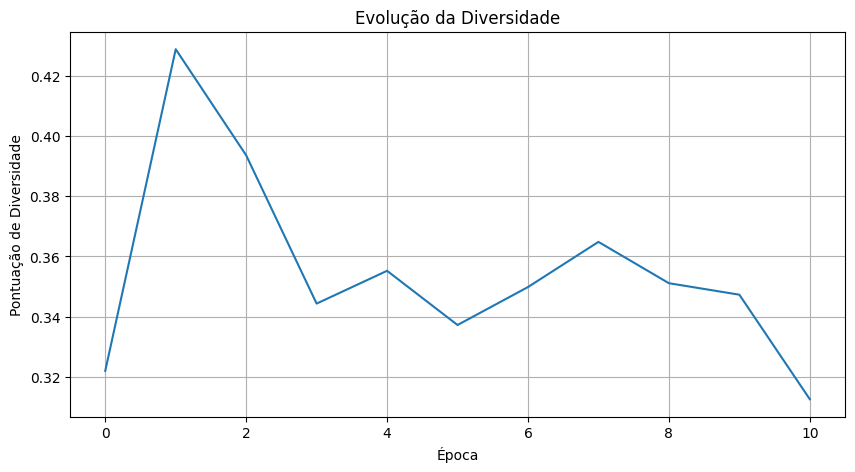

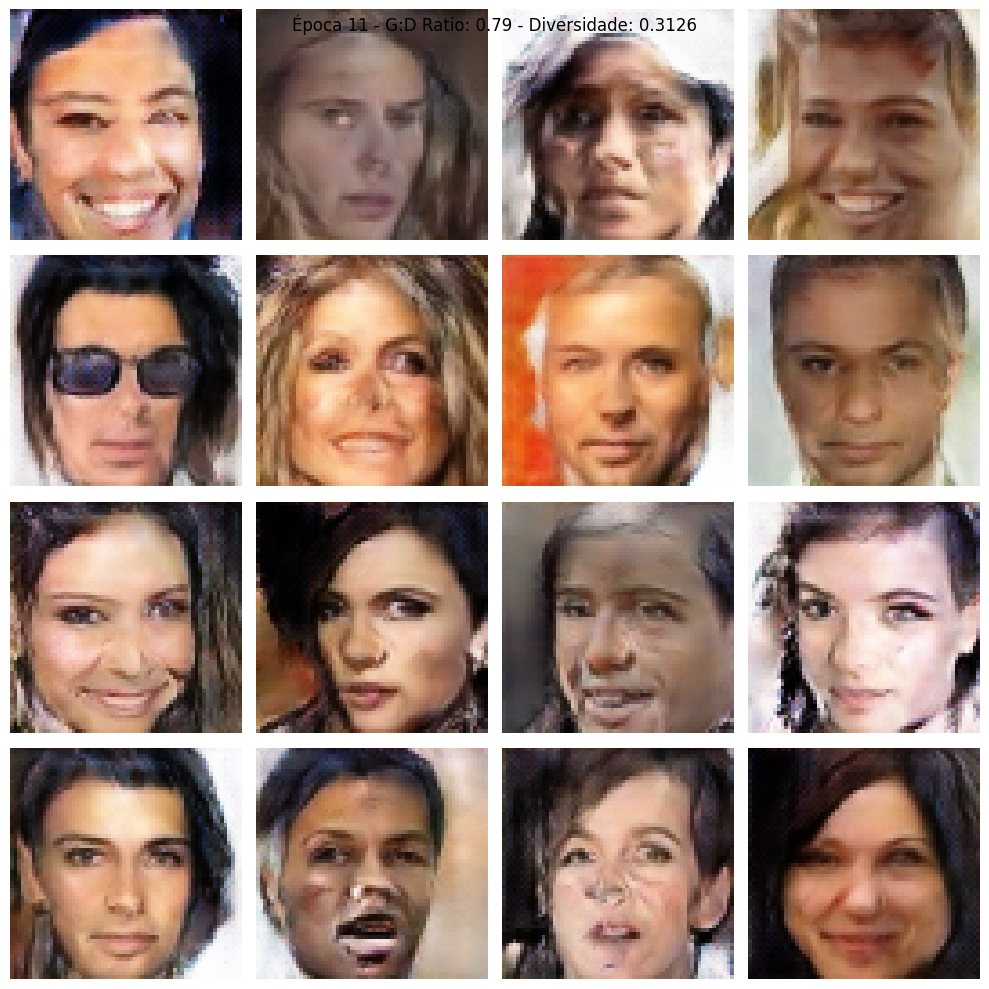

Época 11: 56.74 segundos
Perda média G: 0.9878, Perda média D: 1.2459, Razão G:D: 0.79, Diversidade: 0.3126
Taxa LR G: 0.00012000, Taxa LR D: 0.00030000
--------------------------------------------------------------------------------
Época 12/150
  Batch 20, Perda G: 0.9774, Perda D: 1.4664, Médias - G: 0.9475, D: 1.2230
  Batch 40, Perda G: 0.7309, Perda D: 1.2855, Médias - G: 0.9371, D: 1.2224
  Batch 60, Perda G: 0.6587, Perda D: 1.3038, Médias - G: 0.9439, D: 1.2296
  Batch 80, Perda G: 1.1905, Perda D: 1.1825, Médias - G: 0.9671, D: 1.2275
  Batch 100, Perda G: 0.9365, Perda D: 1.2895, Médias - G: 0.9802, D: 1.2288
  Batch 120, Perda G: 0.7546, Perda D: 1.3119, Médias - G: 0.9872, D: 1.2288
  Batch 140, Perda G: 0.9755, Perda D: 1.1846, Médias - G: 0.9874, D: 1.2249
  Batch 160, Perda G: 0.9184, Perda D: 1.2431, Médias - G: 0.9862, D: 1.2244
  Batch 180, Perda G: 1.0189, Perda D: 1.1898, Médias - G: 0.9926, D: 1.2263
  Batch 200, Perda G: 0.6431, Perda D: 1.2694, Médias - G: 0.988

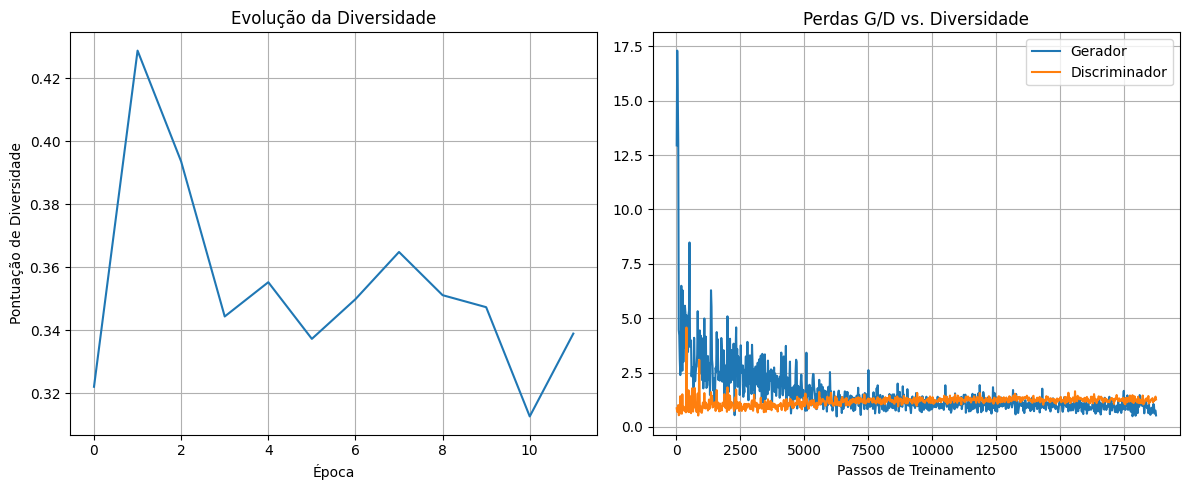

Treinamento concluído com sucesso!


In [ ]:
# Iniciar treinamento
try:
    train(dataset, EPOCHS, start_epoch)
    print("Treinamento concluído com sucesso!")
except KeyboardInterrupt:
    print("Treinamento interrompido pelo usuário.")
    print("O último checkpoint ainda está salvo.")
except Exception as e:
    print(f"Erro durante o treinamento: {e}")

# 12: Visualizar histórico de perdas

Após o treinamento, podemos visualizar o histórico de perdas
para entender como o treinamento progrediu.

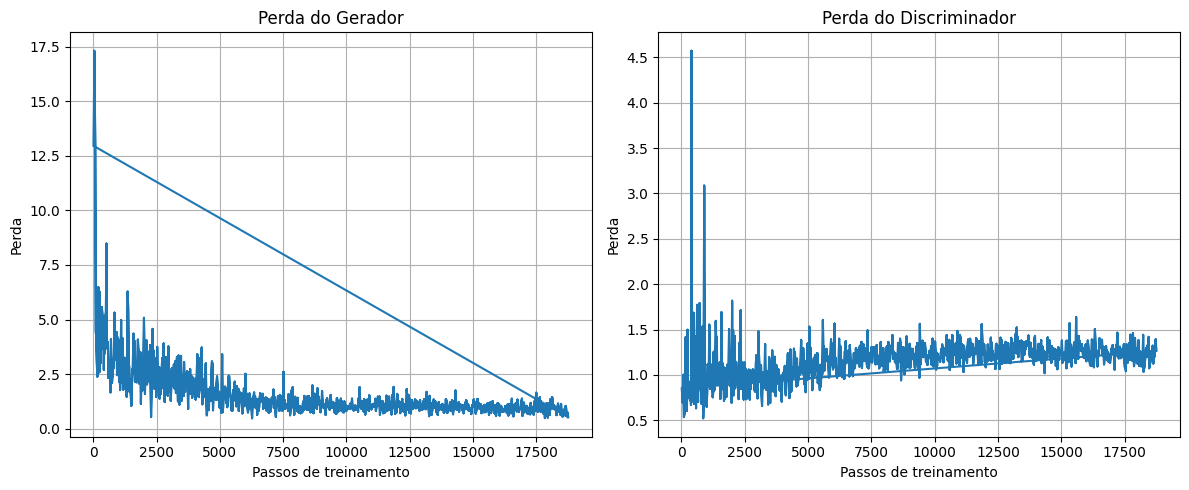

In [ ]:
# Carregar histórico salvo (se o treinamento foi encerrado/reiniciado)
try:
    if os.path.exists(f'{LOG_DIR}/history.npy'):
        saved_history = np.load(f'{LOG_DIR}/history.npy', allow_pickle=True).item()
        # Mesclar com histórico atual se necessário
        if len(history['steps']) > 0:
            for key in history.keys():
                history[key] = list(saved_history[key]) + history[key]
        else:
            history = saved_history
except Exception as e:
    print(f"Não foi possível carregar o histórico salvo: {e}")

# Plotar histórico de perdas
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['steps'], history['gen_loss'], label='Gerador')
plt.xlabel('Passos de treinamento')
plt.ylabel('Perda')
plt.title('Perda do Gerador')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['steps'], history['disc_loss'], label='Discriminador')
plt.xlabel('Passos de treinamento')
plt.ylabel('Perda')
plt.title('Perda do Discriminador')
plt.grid(True)

plt.tight_layout()
plt.savefig(f'{LOG_DIR}/loss_history.png')
plt.show()

# 13: Visualizar evolução do gerador

Aqui visualizamos como a qualidade das imagens geradas evoluiu ao longo do treinamento,
criando uma grade de imagens de diferentes épocas.

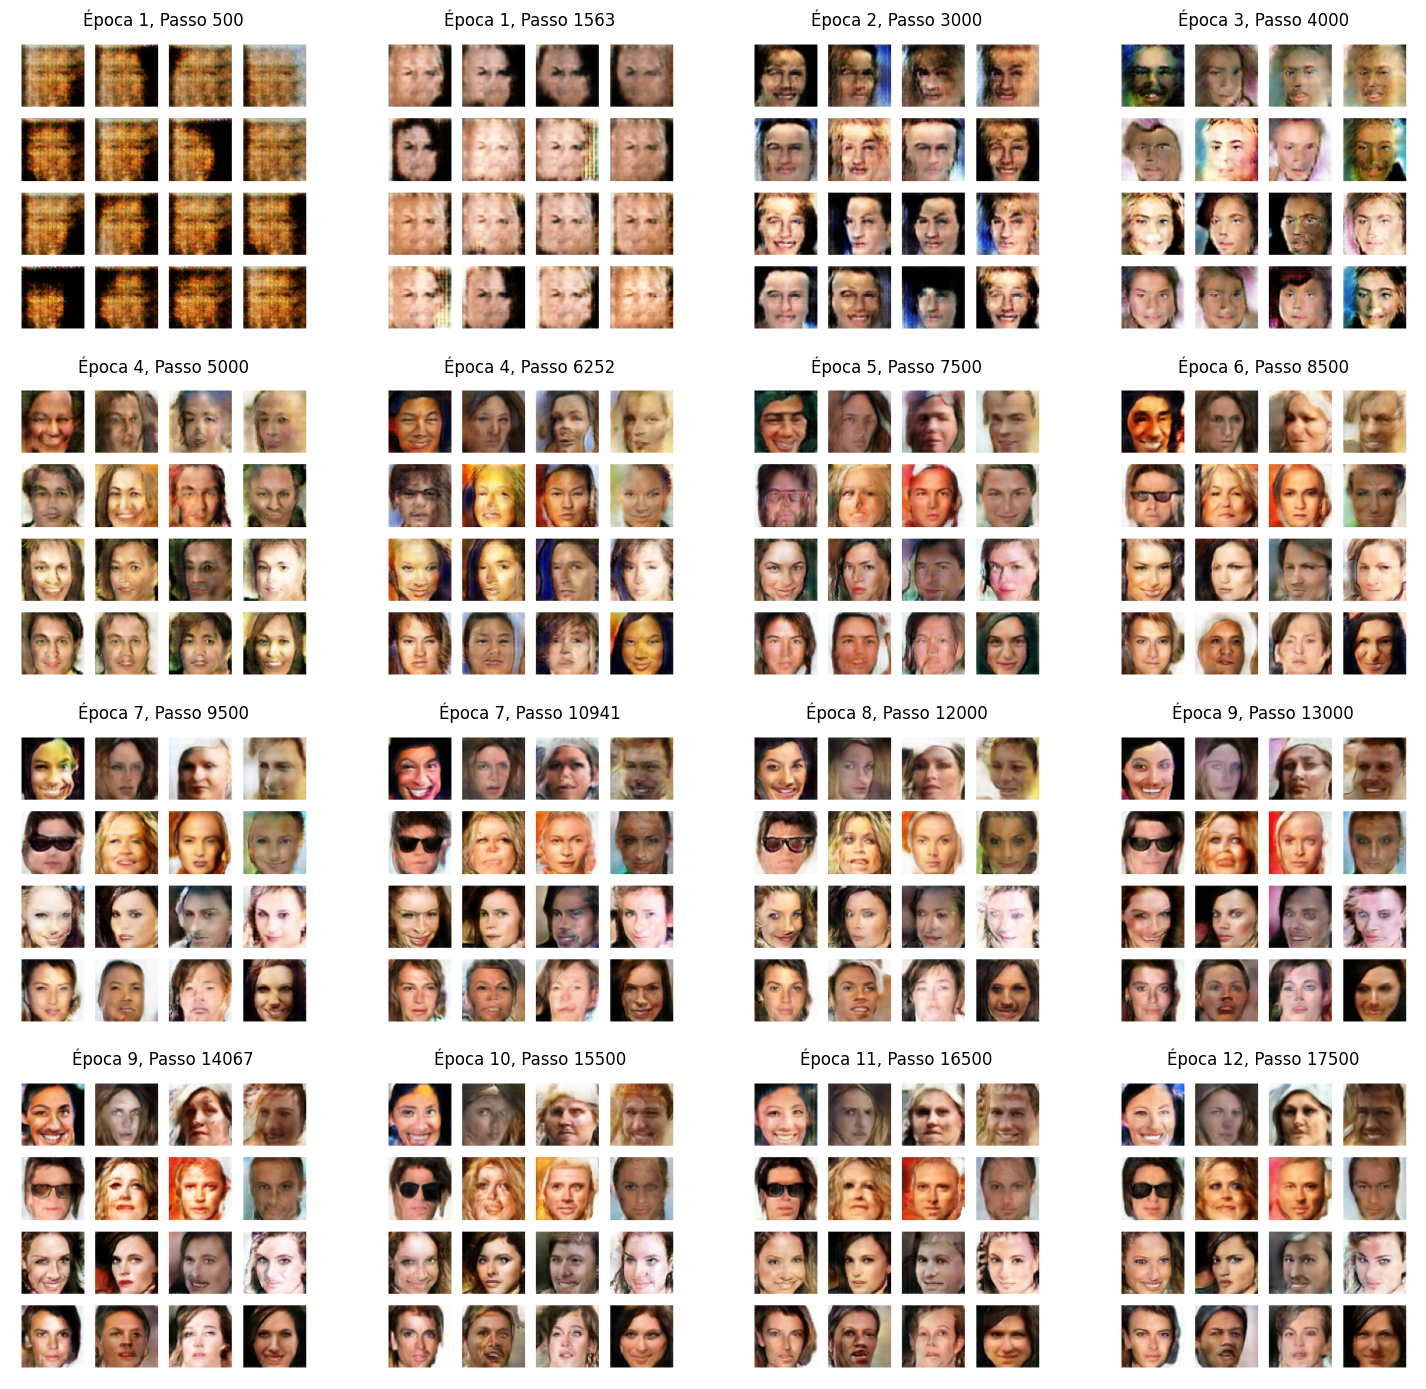

In [ ]:
def create_evolution_grid():
    """Cria uma grade mostrando a evolução das imagens geradas."""
    # Encontrar arquivos de imagens geradas
    image_files = sorted([f for f in os.listdir(LOG_DIR) if f.startswith('image_at_epoch')])

    if len(image_files) == 0:
        print("Nenhuma imagem encontrada para visualizar evolução.")
        return

    # Selecionar um subconjunto para visualização
    n_images = min(16, len(image_files))
    selected_files = image_files[::max(1, len(image_files)//n_images)][:n_images]

    # Criar grade
    cols = min(4, n_images)
    rows = (n_images + cols - 1) // cols
    plt.figure(figsize=(15, rows * 3.5))

    for i, file in enumerate(selected_files):
        # Extrair número da época do nome do arquivo
        epoch = int(file.split('_')[3])
        step = int(file.split('_')[5].split('.')[0])

        plt.subplot(rows, cols, i+1)
        img = plt.imread(os.path.join(LOG_DIR, file))
        plt.imshow(img)
        plt.title(f'Época {epoch}, Passo {step}')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'{LOG_DIR}/evolution_grid.png')
    plt.show()

# Visualizar evolução
create_evolution_grid()

# 14: Gerar um conjunto final de faces

Agora geramos um conjunto final de faces usando nosso gerador treinado.

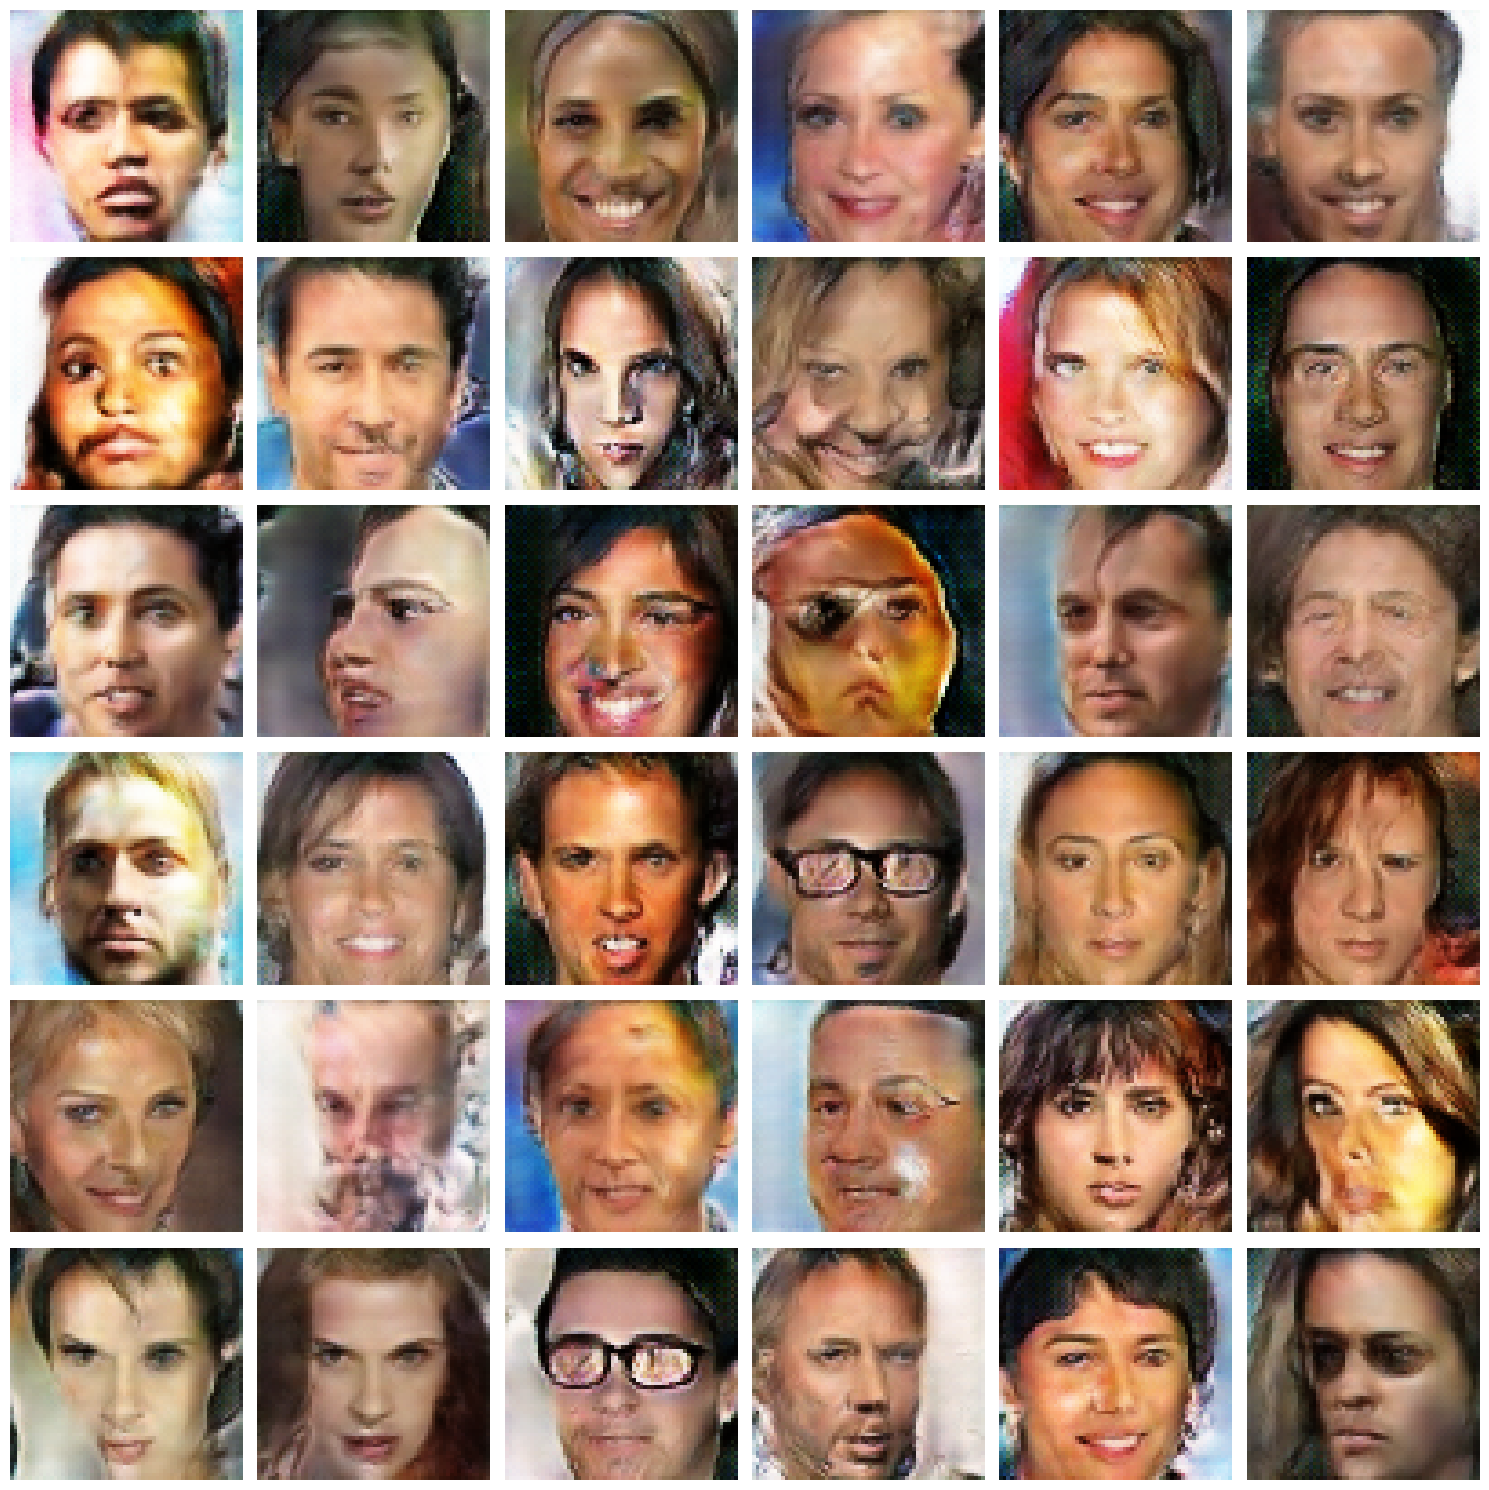

64 imagens geradas e salvas em ./logs/final_samples/


In [ ]:
def generate_final_samples(n_samples=100):
    """Gera e salva um conjunto de samples finais."""
    os.makedirs(f'{LOG_DIR}/final_samples', exist_ok=True)

    # Gerar múltiplos lotes de imagens
    n_batches = (n_samples + 15) // 16  # Arredonda para cima

    all_samples = []
    for i in range(n_batches):
        noise = tf.random.normal([16, LATENT_DIM])
        images = generator(noise, training=False)
        all_samples.append(images)

    # Concatenar todos os lotes
    all_images = tf.concat(all_samples, axis=0)[:n_samples]

    # Mostrar grade de imagens (até 36 para não sobrecarregar)
    display_count = min(36, n_samples)
    rows = int(np.sqrt(display_count))
    cols = (display_count + rows - 1) // rows

    plt.figure(figsize=(15, 15))
    for i in range(display_count):
        plt.subplot(rows, cols, i+1)
        plt.imshow((all_images[i, :, :, :] * 0.5 + 0.5))
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'{LOG_DIR}/final_samples/grid.png')
    plt.show()

    # Salvar cada imagem individualmente
    for i in range(n_samples):
        plt.figure(figsize=(5, 5))
        plt.imshow((all_images[i, :, :, :] * 0.5 + 0.5))
        plt.axis('off')
        plt.savefig(f'{LOG_DIR}/final_samples/sample_{i:03d}.png')
        plt.close()

    print(f"{n_samples} imagens geradas e salvas em {LOG_DIR}/final_samples/")

# Gerar amostras finais
generate_final_samples(n_samples=64)

# 15: Explorar o espaço latente

Aqui exploramos o espaço latente realizando interpolação entre pontos,
o que nos permite ver como a face muda gradualmente entre diferentes pontos.

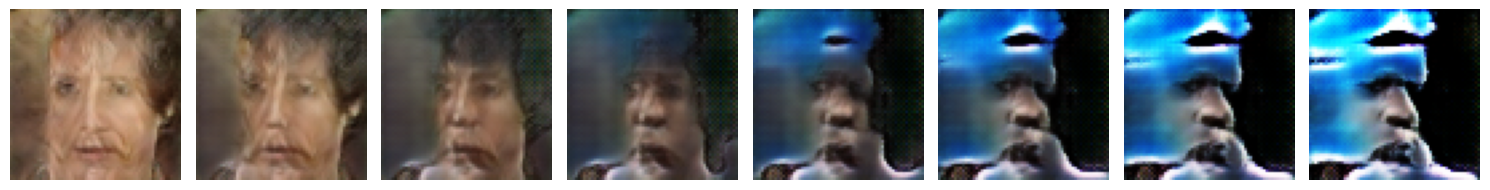

In [ ]:
def interpolate_latent_space(n_steps=10):
    """Mostra interpolação no espaço latente entre dois pontos."""
    # Gerar dois pontos latentes aleatórios
    z1 = tf.random.normal([1, LATENT_DIM])
    z2 = tf.random.normal([1, LATENT_DIM])

    # Gerar pontos intermediários
    alphas = np.linspace(0, 1, n_steps)
    z_interp = [z1 * (1-alpha) + z2 * alpha for alpha in alphas]

    # Gerar imagens
    images = [generator(z, training=False)[0] for z in z_interp]

    # Exibir interpolação
    plt.figure(figsize=(15, 3))
    for i, img in enumerate(images):
        plt.subplot(1, n_steps, i+1)
        plt.imshow((img * 0.5 + 0.5))
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'{LOG_DIR}/latent_interpolation.png')
    plt.show()

# Explorar interpolação
interpolate_latent_space(n_steps=8)

# 16: Conclusão e próximos passos

Esta célula contém a conclusão do projeto e sugestões para extensões.

In [ ]:
print("""
Neste projeto, implementamos uma DCGAN (Deep Convolutional Generative Adversarial Network)
capaz de gerar imagens de faces a partir de ruído aleatório.

## O que aprendemos:
1. Como estruturar uma arquitetura DCGAN com gerador e discriminador
2. Técnicas de pré-processamento de imagens para treinar GANs
3. Implementação do loop de treinamento adversarial em TensorFlow
4. Visualização e monitoramento do progresso durante o treinamento
5. Como salvar checkpoints e restaurar modelos para continuar o treinamento

## Extensões possíveis:
1. Aumentar a resolução para 128x128 ou maior (exige arquitetura mais profunda)
2. Implementar controle sobre atributos específicos (GAN condicional)
3. Treinar por mais épocas para melhorar a qualidade das imagens
4. Experimentos com diferentes arquiteturas (StyleGAN, WGAN, etc.)
5. Implementar métricas de avaliação como FID (Fréchet Inception Distance)

## Referências:
- Paper DCGAN original: Radford et al. (2015), "Unsupervised Representation Learning with Deep Convolutional GANs"
- TensorFlow Tutorial sobre DCGAN: https://www.tensorflow.org/tutorials/generative/dcgan
""")

# Salvar modelos em formato nativo Keras para uso futuro
try:
    generator.save(f'{LOG_DIR}/generator_model.keras')  # Adiciona a extensão .keras
    discriminator.save(f'{LOG_DIR}/discriminator_model.keras')  # Adiciona a extensão .keras
    print("Modelos salvos com sucesso!")
except Exception as e:
    print(f"Erro ao salvar modelos: {e}")

print("Notebook concluído! As imagens geradas, logs e modelos estão em:", LOG_DIR)


Neste projeto, implementamos uma DCGAN (Deep Convolutional Generative Adversarial Network)
capaz de gerar imagens de faces a partir de ruído aleatório.

## O que aprendemos:
1. Como estruturar uma arquitetura DCGAN com gerador e discriminador
2. Técnicas de pré-processamento de imagens para treinar GANs
3. Implementação do loop de treinamento adversarial em TensorFlow
4. Visualização e monitoramento do progresso durante o treinamento
5. Como salvar checkpoints e restaurar modelos para continuar o treinamento

## Extensões possíveis:
1. Aumentar a resolução para 128x128 ou maior (exige arquitetura mais profunda)
2. Implementar controle sobre atributos específicos (GAN condicional)
3. Treinar por mais épocas para melhorar a qualidade das imagens
4. Experimentos com diferentes arquiteturas (StyleGAN, WGAN, etc.)
5. Implementar métricas de avaliação como FID (Fréchet Inception Distance)

## Referências:
- Paper DCGAN original: Radford et al. (2015), "Unsupervised Representation Learning w